In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.all import (
    ModelVisualizer,
    StartMeshcat,
    Simulator,
    DiagramBuilder,
    LogVectorOutput,
)

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
import matplotlib.pyplot as plt
import numpy as np

import sponana.utils
from sponana.perception import (
    BananaSpotter,
    add_camera_pose_extractor,
    add_body_pose_extractor,
)
from sponana.controller import SpotController, solve_ik
from sponana.debug_logger import DebugLogger

In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [4]:
inspect_spot_model = False

if inspect_spot_model:
    # Inspecting the Spot Model
    visualizer = ModelVisualizer(meshcat=meshcat)
    sponana.utils.configure_parser(visualizer.parser())
    visualizer.AddModels(
        url="package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf"
    )
    visualizer.Run(loop_once=not running_as_notebook)
    meshcat.DeleteAddedControls()

In [63]:
def create_scene(scenario_data: str, debug: bool = True):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    scenario = load_scenario(data=scenario_data)
    station = builder.AddSystem(
        MakeHardwareStation(
            scenario, meshcat, parser_preload_callback=sponana.utils.configure_parser
        )
    )

    spot_plant = station.GetSubsystemByName(
        "spot.controller"
    ).get_multibody_plant_for_control()
    spot_controller = builder.AddSystem(SpotController(spot_plant, meshcat=meshcat))
    builder.Connect(
        spot_controller.get_output_port(),
        station.GetInputPort("spot.desired_state"),
    )

    # Get camera poses
    spot_camera_config = scenario.cameras["spot_camera"]
    camera_pose_extractor = add_camera_pose_extractor(
        spot_camera_config, station, builder
    )

    # Camera to Perception
    spot_camera = station.GetSubsystemByName("rgbd_sensor_spot_camera")
    banana_spotter = builder.AddSystem(BananaSpotter(spot_camera))
    banana_spotter.set_name("banana_spotter")
    builder.Connect(
        station.GetOutputPort("spot_camera.rgb_image"),
        banana_spotter.get_color_image_input_port(),
    )
    builder.Connect(
        station.GetOutputPort("spot_camera.depth_image"),
        banana_spotter.get_depth_image_input_port(),
    )

    # Banana pose (for debugging)
    banana_pose_extractor = add_body_pose_extractor(
        "banana", "banana", station, builder
    )
    builder.Connect(
        banana_pose_extractor.get_output_port(),
        spot_controller.GetInputPort("desired_gripper_pose"),
    )

    if debug:
        # Connect debugger
        debugger = builder.AddNamedSystem(
            "debug_logger", DebugLogger(spot_camera, meshcat)
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.rgb_image"),
            debugger.get_color_image_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot_camera.depth_image"),
            debugger.get_depth_image_input_port(),
        )
        builder.Connect(
            camera_pose_extractor.get_output_port(),
            debugger.get_camera_pose_input_port(),
        )
        builder.Connect(
            station.GetOutputPort("spot.state_estimated"),
            debugger.get_spot_state_input_port(),
        )
        builder.Connect(
            banana_pose_extractor.get_output_port(),
            debugger.get_banana_pose_input_port(),
        )

    diagram = builder.Build()
    diagram.set_name("everything")  # the outmost diagram
    return diagram

In [25]:
scenario_data = """
cameras:
    spot_camera:
        name: spot_camera
        depth: True
        X_PB:
            translation: [0, 0.05, 0]
            base_frame: spot_camera::base
            rotation: !Rpy { deg: [-90, 0, 0] }

directives:
- add_model:
    name: spot
    file: package://manipulation/spot/spot_with_arm_and_floating_base_actuators.urdf
    default_joint_positions:
        arm_sh1: [-3.1]
        arm_el0: [3.1]
    
- add_model:
    name: banana
    file: package://sponana/banana/banana.sdf
    default_free_body_pose:
        banana:
            # move it in front of Spot 
            translation: [0.45, 0, 0.05]

- add_model:
    name: floor
    file: package://sponana/platform.sdf

- add_weld:
    parent: world
    child: floor::platform_center

- add_model:
    name: spot_camera
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: spot::body
    child: spot_camera::base
    X_PC:
        translation: [0.4, 0, 0]
        rotation: !Rpy { deg: [-30, 0, -90] }

model_drivers:
    spot: !InverseDynamicsDriver {}
"""

Logging system info...
Camera pose: RigidTransform(
  R=RotationMatrix([
    [1.583848449927165e-08, -0.49999999999999983, 0.8660254037844386],
    [-0.9999999999999999, -7.919242249635822e-09, 1.3716529933815306e-08],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[-0.009380219096421213, 6.873976304740825e-09, 0.495],
)


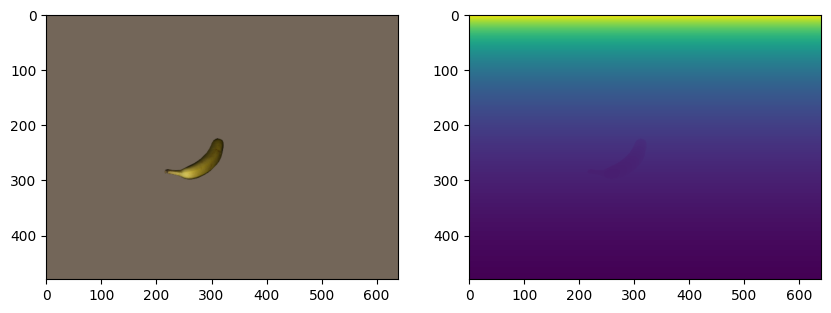

In [30]:
diagram = create_scene(scenario_data)
simulator = Simulator(diagram)
sponana.utils.run_simulation(simulator, meshcat, finish_time=-1)

In [36]:
# test banana spotter
context = simulator.get_mutable_context()
banana_spotter = diagram.GetSubsystemByName("banana_spotter")
context = banana_spotter.GetMyContextFromRoot(context)
has_banana = banana_spotter.GetOutputPort("has_banana").Eval(context)
print("has_banana", has_banana)  # this value is currently being hard-coded

has_banana [1.]


In [ ]:
# another way to get the images directly
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

In [38]:
# camera intrinsics
spot_camera = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = spot_camera.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

intrinsics [[579.41125497   0.         319.5       ]
 [  0.         579.41125497 239.5       ]
 [  0.           0.           1.        ]]
focal length 579.4112549695427 579.4112549695427
field of view 1.009191289973297 0.7853981633974485


In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)